#### Import python files from another directory
In order to reuse code written in .py files you need to import them.
If they are from a distant folder, rather than copy-paste it into the current folder, you can write:

In [1]:
import sys

sys.path.append(
    "../../ex02/template"
)  # This goes up twice in the directories tree (hence in labs)
# then goes down to ex02/template where your files from lab 2 are.

you can now import your desired files, for example, we can import grid_search.py with:

In [2]:
import grid_search  # You then need to call your functions using grid_search.function_name()
import grid_search as gs  # You then need to call your functions using gs.function_name()
from grid_search import *  # You can call any functions of the file with function_name()

# Let's try to call generate_w from grid_search.py:
w0, w1 = generate_w(5)
print(w0, w1)

[-100.  -25.   50.  125.  200.] [-150.  -75.    0.   75.  150.]


As you can see we are now able to call functions from the grid_search.py file.

In [3]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from helpers import *

from test_utils import test

%load_ext autoreload
%autoreload 2

# 1 Least squares and linear basis functions models
## 1.1 Least squares

In [4]:
def least_squares(y, tx):
    """Calculate the least squares solution.
       returns mse, and optimal weights.

    Args:
        y: numpy array of shape (N,), N is the number of samples.
        tx: numpy array of shape (N,D), D is the number of features.

    Returns:
        w: optimal weights, numpy array of shape(D,), D is the number of features.
        mse: scalar.

    >>> least_squares(np.array([0.1,0.2]), np.array([[2.3, 3.2], [1., 0.1]]))
    (array([ 0.21212121, -0.12121212]), 8.666684749742561e-33)
    """
    # Normal equation: w = (X^T X)^-1 X^T y
    w = np.linalg.solve(tx.T @ tx, tx.T @ y)
    
    # Compute the residuals: e = y - Xw
    e = y - tx @ w
    
    # Compute the Mean Squared Error (MSE)
    mse = np.mean(e**2) / 2
    
    return w, float(mse)

### You can test your implementation here

In [5]:
test(least_squares)
# NB:
#
# Due to precision issues,
# the output might not be exactly the same
# even if you have implemented the right code.
#
# For example, the mse output expected to be
# 8.666684749742561e-33,
# but you might get some other small number
# close to zero.
#
# In this case,
# Failing the test doesn't necessarily mean
# your implementation is wrong.:)

✅ Your `least_squares` passed 1 tests.


### Load the data
Here we will reuse the dataset `height_weight_genders.csv` from previous exercise section to check the correctness of your implementation. Please compare it with your previous result.

In [6]:
from gradient_descent import gradient_descent
from costs import compute_loss

def test_your_least_squares():
    """
    This code compares the optimal weights obtained
    by least squares vs. gradient descent.
    """
    height, weight, gender = load_data_from_ex02(sub_sample=False, add_outlier=False)
    x, mean_x, std_x = standardize(height)
    y, tx = build_model_data(x, weight)

    # Perform least squares
    w_ls, mse_ls = least_squares(y, tx)

    print("Least Squares Results:")
    print("Optimal weights (w_ls):", w_ls)
    print("MSE (mse_ls):", mse_ls)

    # Define parameters for gradient descent
    max_iters = 50
    gamma = 0.7
    initial_w = np.array([0.0, 0.0])

    # Perform gradient descent
    losses_gd, ws_gd = gradient_descent(y, tx, initial_w, max_iters, gamma)

    # Take the final weights and loss from gradient descent
    w_gd = ws_gd[-1]
    mse_gd = losses_gd[-1]

    # Print gradient descent results
    print("\nGradient Descent Results:")
    print("Optimal weights (w_gd):", w_gd)
    print("MSE (mse_gd):", mse_gd)

    # Compare the results
    print("\nComparison:")
    print("Difference in weights:", w_ls - w_gd)
    print("Difference in MSE:", mse_ls - mse_gd)

    # least square or grid search: TODO
    # this code should compare the optimal weights obtained
    # by least squares vs. grid search
    # ***************************************************

Test it here

In [7]:
test_your_least_squares()

Least Squares Results:
Optimal weights (w_ls): [73.293922   13.47971243]
MSE (mse_ls): 15.3858878688294
GD iter. 0/49: loss=2792.2367127591674, w0=51.30574540147368, w1=9.435798704492347
GD iter. 1/49: loss=265.3024621089587, w0=66.69746902191575, w1=12.266538315840018
GD iter. 2/49: loss=37.87837955044096, w0=71.31498610804836, w1=13.115760199244335
GD iter. 3/49: loss=17.41021212017444, w0=72.70024123388815, w1=13.370526764265632
GD iter. 4/49: loss=15.568077051450448, w0=73.11581777164008, w1=13.446956733772025
GD iter. 5/49: loss=15.402284895265295, w0=73.24049073296565, w1=13.469885724623941
GD iter. 6/49: loss=15.38736360120863, w0=73.27789262136334, w1=13.476764421879516
GD iter. 7/49: loss=15.38602068474353, w0=73.28911318788263, w1=13.478828031056189
GD iter. 8/49: loss=15.385899822261674, w0=73.29247935783842, w1=13.47944711380919
GD iter. 9/49: loss=15.385888944638305, w0=73.29348920882515, w1=13.47963283863509
GD iter. 10/49: loss=15.3858879656522, w0=73.29379216412117, w1=

## 1.2 Least squares with a linear basis function model
Start from this section, we will use the dataset `dataEx3.csv`.

### Implement polynomial basis functions

In [8]:
def build_poly(x, degree):
    """polynomial basis functions for input data x, for j=0 up to j=degree.

    Args:
        x: numpy array of shape (N,), N is the number of samples.
        degree: integer.

    Returns:
        poly: numpy array of shape (N,d+1)

    >>> build_poly(np.array([0.0, 1.5]), 2)
    array([[1.  , 0.  , 0.  ],
           [1.  , 1.5 , 2.25]])
    """
    return np.vstack([x**d for d in range(degree + 1)]).T
    #return np.column_stack([x**d for d in range(degree + 1)])


In [9]:
test(build_poly)

✅ Your `build_poly` passed 1 tests.


Once your implementation of `build_poly` passes the test, copy it to `build_polynomial.py`
Let us play with polynomial regression. Note that we will use your implemented function `compute_mse`. Please copy and paste your implementation from exercise02.

In [10]:
from plots import *
from costs import compute_loss

def polynomial_regression():
    """Construct polynomial basis function expansion of the data,
    and then run least squares regression."""
    # Define parameters
    degrees = [1, 3, 7, 12]

    # Define the structure of the figure
    num_row = 2
    num_col = 2
    f, axs = plt.subplots(num_row, num_col)

    # Load data
    x, y = load_data()

    for ind, degree in enumerate(degrees):
        # Construct polynomial features
        tx_poly = build_poly(x, degree)

        # Perform least squares regression
        weights, mse = least_squares(y, tx_poly)

        # Calculate RMSE
        rmse = np.sqrt(2 * mse)

        # Print results
        print(
            "Processing {i}th experiment, degree={d}, rmse={loss:.3f}".format(
                i=ind + 1, d=degree, loss=rmse
            )
        )

        # Plot fit
        plot_fitted_curve(y, x, weights, degree, axs[ind // num_col][ind % num_col])

    plt.tight_layout()
    plt.show()

Run polynomial regression

Processing 1th experiment, degree=1, rmse=0.472
Processing 2th experiment, degree=3, rmse=0.259
Processing 3th experiment, degree=7, rmse=0.250
Processing 4th experiment, degree=12, rmse=0.243


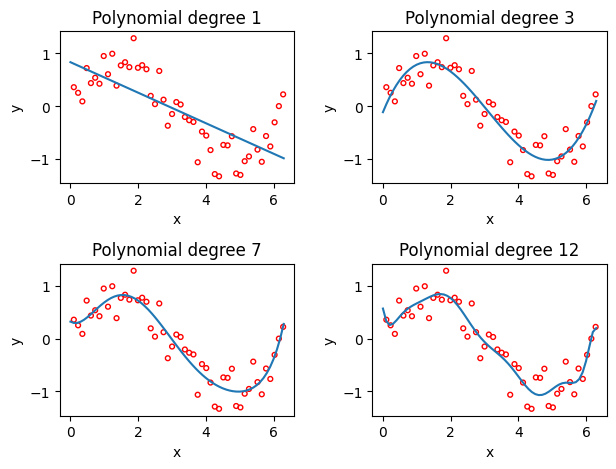

In [11]:
polynomial_regression()

Your results should look like this:

![alt text](visualize_polynomial_regression.png)

# 2 Evaluating model predication performance

Let us show the train and test splits for various polynomial degrees. First of all, please fill in the function `split_data()`

In [12]:
def split_data(x, y, ratio, seed=1):
    """
    split the dataset based on the split ratio. If ratio is 0.8
    you will have 80% of your data set dedicated to training
    and the rest dedicated to testing. If ratio times the number of samples is not round
    you can use np.floor. Also check the documentation for np.random.permutation,
    it could be useful.

    Args:
        x: numpy array of shape (N,), N is the number of samples.
        y: numpy array of shape (N,).
        ratio: scalar in [0,1]
        seed: integer.

    Returns:
        x_tr: numpy array containing the train data.
        x_te: numpy array containing the test data.
        y_tr: numpy array containing the train labels.
        y_te: numpy array containing the test labels.

    >>> split_data(np.arange(13), np.arange(13), 0.8, 1)
    (array([ 2,  3,  4, 10,  1,  6,  0,  7, 12,  9]), array([ 8, 11,  5]), array([ 2,  3,  4, 10,  1,  6,  0,  7, 12,  9]), array([ 8, 11,  5]))
    """
    # Set seed for reproducibility
    np.random.seed(seed)
    
    # Shuffle the data
    indices = np.random.permutation(len(x))
    
    # Compute the split index
    split_index = int(np.floor(len(x) * ratio))
    
    # Split the indices
    train_indices = indices[:split_index]
    test_indices = indices[split_index:]
    
    # Create train and test datasets
    x_tr, x_te = x[train_indices], x[test_indices]
    y_tr, y_te = y[train_indices], y[test_indices]
    
    return x_tr, x_te, y_tr, y_te

In [13]:
test(split_data)

✅ Your `split_data` passed 1 tests.


Then, test your `split_data` function below.

In [16]:
def train_test_split_demo(x, y, degree, ratio, seed):
    """Polynomial regression with different split ratios and different degrees.

    Returns:
      x_tr: numpy array
      x_te: numpy array
      y_tr: numpy array
      y_te: numpy array
      weights: weights from the least squares optimization
    """
    # Split the data
    x_tr, x_te, y_tr, y_te = split_data(x, y, ratio, seed)
    
    # Form train and test data with polynomial basis function
    tx_tr = build_poly(x_tr, degree)
    tx_te = build_poly(x_te, degree)
    
    # Calculate weights through least squares
    weights_tr, train_mse = least_squares(y_tr, tx_tr)
    weights_te, test_mse = least_squares(y_te, tx_te)

    # Calculate RMSE for train and test data
    #train_mse = compute_loss(y_tr, tx_tr, weights_tr)
    #test_mse = compute_loss(y_te, tx_te, weights_te)
    
    rmse_tr = np.sqrt(2 * train_mse)
    rmse_te = np.sqrt(2 * test_mse)
    
    # Print results
    print(
        "proportion={p}, degree={d}, Training RMSE={tr:.3f}, Testing RMSE={te:.3f}".format(
            p=ratio, d=degree, tr=rmse_tr, te=rmse_te
        )
    )
    
    return x_tr, x_te, y_tr, y_te, weights_tr

Demo time

proportion=0.9, degree=1, Training RMSE=0.494, Testing RMSE=0.157
proportion=0.9, degree=3, Training RMSE=0.264, Testing RMSE=0.086
proportion=0.9, degree=7, Training RMSE=0.254, Testing RMSE=0.000
proportion=0.9, degree=12, Training RMSE=0.242, Testing RMSE=0.000
proportion=0.7, degree=1, Training RMSE=0.516, Testing RMSE=0.327
proportion=0.7, degree=3, Training RMSE=0.249, Testing RMSE=0.184
proportion=0.7, degree=7, Training RMSE=0.227, Testing RMSE=0.121
proportion=0.7, degree=12, Training RMSE=0.223, Testing RMSE=0.055
proportion=0.5, degree=1, Training RMSE=0.455, Testing RMSE=0.450
proportion=0.5, degree=3, Training RMSE=0.239, Testing RMSE=0.255
proportion=0.5, degree=7, Training RMSE=0.232, Testing RMSE=0.247
proportion=0.5, degree=12, Training RMSE=0.205, Testing RMSE=0.228
proportion=0.1, degree=1, Training RMSE=0.428, Testing RMSE=0.468
proportion=0.1, degree=3, Training RMSE=0.085, Testing RMSE=0.251
proportion=0.1, degree=7, Training RMSE=0.000, Testing RMSE=0.247
proport

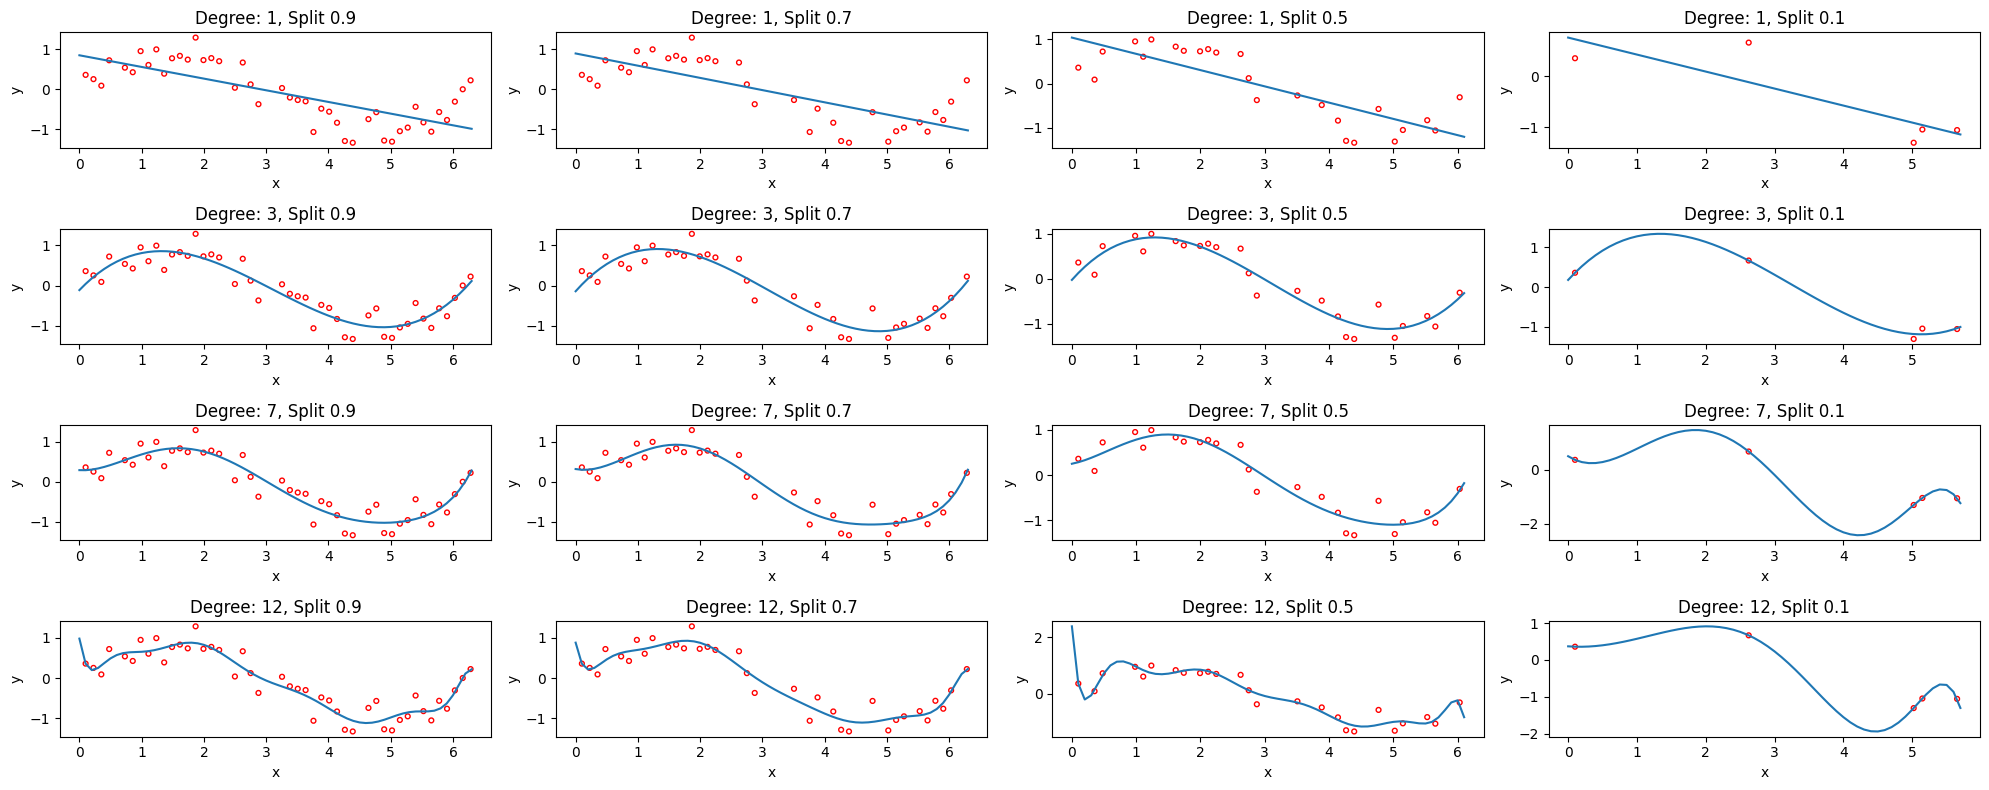

In [17]:
x, y = load_data()
seed = 6
degrees = [1, 3, 7, 12]
split_ratios = [0.9, 0.7, 0.5, 0.1]

# define the structure of the figure
num_row = 4
num_col = 4
axs = plt.subplots(num_row, num_col, figsize=(20, 8))[1]

for ind, split_ratio in enumerate(split_ratios):
    for ind_d, degree in enumerate(degrees):
        x_tr, x_te, y_tr, y_te, w = train_test_split_demo(
            x, y, degree, split_ratio, seed
        )
        plot_fitted_curve(y_tr, x_tr, w, degree, axs[ind_d][ind % num_col])
        axs[ind_d][ind].set_title(f"Degree: {degree}, Split {split_ratio}")
plt.tight_layout()

Your graph should look like this:

![alt text](split_demo.png)

# Ridge Regression
Please fill in the function below.

In [42]:
def ridge_regression(y, tx, lambda_):
    """implement ridge regression.

    Args:
        y: numpy array of shape (N,), N is the number of samples.
        tx: numpy array of shape (N,D), D is the number of features.
        lambda_: scalar.

    Returns:
        w: optimal weights, numpy array of shape(D,), D is the number of features.

    >>> ridge_regression(np.array([0.1,0.2]), np.array([[2.3, 3.2], [1., 0.1]]), 0)
    array([ 0.21212121, -0.12121212])
    >>> ridge_regression(np.array([0.1,0.2]), np.array([[2.3, 3.2], [1., 0.1]]), 1)
    array([0.03947092, 0.00319628])
    """
    # Number of samples
    N = tx.shape[0]
    
    # Add regularization term to the normal equation
    I = np.identity(tx.shape[1])  # Identity matrix of shape (D, D)
    # Compute the ridge regression weights
    w = np.linalg.inv(tx.T @ tx + lambda_ * I) @ tx.T @ y
    
    return w

In [ ]:
test(ridge_regression)

In [43]:
def ridge_regression_demo(x, y, degree, ratio, seed):
    """ridge regression demo."""
    # Define parameter
    lambdas = np.logspace(-5, 0, 15)

    # Split the data
    x_tr, x_te, y_tr, y_te = split_data(x, y, ratio, seed)

    # Form train and test data with polynomial basis function
    tx_tr = build_poly(x_tr, degree)
    tx_te = build_poly(x_te, degree)

    rmse_tr = []
    rmse_te = []
    
    for lambda_ in lambdas:
        # Ridge regression with a given lambda
        w = ridge_regression(y_tr, tx_tr, lambda_)
        
        # Predict train and test data
        y_tr_pred = tx_tr @ w
        y_te_pred = tx_te @ w
        
        # Calculate RMSE for train and test data
        rmse_tr.append(np.sqrt(np.mean((y_tr - y_tr_pred)**2)))
        rmse_te.append(np.sqrt(np.mean((y_te - y_te_pred)**2)))
        
        print(
            "proportion={p}, degree={d}, lambda={l:.3f}, Training RMSE={tr:.3f}, Testing RMSE={te:.3f}".format(
                p=ratio, d=degree, l=lambda_, tr=rmse_tr[-1], te=rmse_te[-1]
            )
        )

    # Plot results
    plot_train_test(rmse_tr, rmse_te, lambdas, degree)

Demo time

proportion=0.5, degree=7, lambda=0.000, Training RMSE=0.227, Testing RMSE=0.338
proportion=0.5, degree=7, lambda=0.000, Training RMSE=0.227, Testing RMSE=0.338
proportion=0.5, degree=7, lambda=0.000, Training RMSE=0.227, Testing RMSE=0.338
proportion=0.5, degree=7, lambda=0.000, Training RMSE=0.227, Testing RMSE=0.338
proportion=0.5, degree=7, lambda=0.000, Training RMSE=0.227, Testing RMSE=0.338
proportion=0.5, degree=7, lambda=0.001, Training RMSE=0.227, Testing RMSE=0.338
proportion=0.5, degree=7, lambda=0.001, Training RMSE=0.227, Testing RMSE=0.337
proportion=0.5, degree=7, lambda=0.003, Training RMSE=0.227, Testing RMSE=0.336
proportion=0.5, degree=7, lambda=0.007, Training RMSE=0.227, Testing RMSE=0.335
proportion=0.5, degree=7, lambda=0.016, Training RMSE=0.228, Testing RMSE=0.334
proportion=0.5, degree=7, lambda=0.037, Training RMSE=0.229, Testing RMSE=0.333
proportion=0.5, degree=7, lambda=0.085, Training RMSE=0.229, Testing RMSE=0.328
proportion=0.5, degree=7, lambda=0.193, 

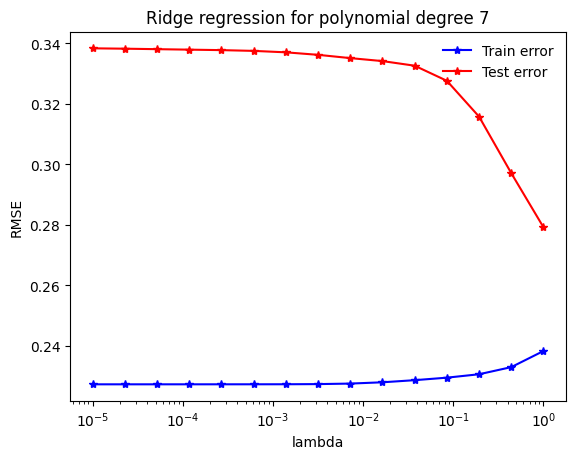

In [44]:
seed = 56
degree = 7
split_ratio = 0.5
ridge_regression_demo(x, y, degree, split_ratio, seed)

Your plot should look like:

![alt text](ridge_regression.png)